In [1]:
!pip -q install -U langchain langchain-community chromadb sentence-transformers pypdf transformers accelerate

!pip -q install -U rank-bm25

import json, sys, platform, os, chromadb, transformers, sentence_transformers, pathlib, datetime, importlib, re
from pathlib import Path

try:
    import torch
    torch_v = torch.__version__
    cuda_ok = torch.cuda.is_available()
    device_name = torch.cuda.get_device_name(0) if cuda_ok else "CPU"
except Exception:
    torch_v, cuda_ok, device_name = "N/A", False, "CPU"

env = {
    "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
    "python": sys.version,
    "platform": platform.platform(),
    "torch": torch_v,
    "cuda": cuda_ok,
    "device": device_name,
    "transformers": transformers.__version__,
    "sentence_transformers": sentence_transformers.__version__,
    "chromadb": chromadb.__version__
}
print(json.dumps(env, indent=2))
with open("env_rag.json","w") as f: json.dump(env, f, indent=2)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.4 MB/s eta

In [2]:
print("\n=== Week 4: Upload your PDFs/TXTs (you can select multiple) ===")
try:
    from google.colab import files
    uploaded = files.upload()
except Exception as e:
    print("Colab upload UI not available. If running locally, place files under ./corpus", e)
    uploaded = {}

CORPUS_DIR = Path("corpus"); CORPUS_DIR.mkdir(exist_ok=True)
for name, data in uploaded.items():
    (CORPUS_DIR / name).write_bytes(data)
all_files = [p for p in CORPUS_DIR.iterdir() if p.is_file()]
print("Saved files:", [p.name for p in all_files] if all_files else "(none uploaded; using existing files in ./corpus if present)")

from langchain_community.document_loaders import PyPDFLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

docs = []
for p in all_files:
    ext = p.suffix.lower()
    try:
        if ext == ".pdf":
            docs.extend(PyPDFLoader(str(p)).load())
        elif ext in [".txt", ".text", ".md"]:
            docs.extend(TextLoader(str(p), encoding="utf-8").load())
        else:
            print(f"[SKIP] Unsupported file type: {p.name}")
    except Exception as e:
        print(f"[WARN] Could not read {p.name}: {e}")

if not docs:
    raise ValueError("No supported documents parsed. Please upload at least one PDF or TXT file into ./corpus.")

# Chunk
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = splitter.split_documents(docs)
print("Chunks:", len(chunks))
if chunks:
    print("First chunk:\n", chunks[0].page_content[:300])

from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_community.vectorstores import Chroma

emb = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectordb = Chroma.from_documents(chunks, emb, persist_directory="chroma_minilm")
retriever = vectordb.as_retriever(search_kwargs={"k": 4})
print("Chroma DB ready")

from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA

MODEL_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tok = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID)
pipe = pipeline("text-generation", model=model, tokenizer=tok, max_new_tokens=128)
llm = HuggingFacePipeline(pipeline=pipe)

qa = RetrievalQA.from_chain_type(llm=llm, retriever=retriever, chain_type="stuff")
print("\n=== Week 4: Sanity QA ===")
print("Q: Give one key topic mentioned in any uploaded paper.")
print("A:", qa.run("Give one key topic mentioned in any uploaded paper."))

emb_e5 = SentenceTransformerEmbeddings(model_name="intfloat/e5-small-v2")
vectordb_e5 = Chroma.from_documents(chunks, emb_e5, persist_directory="chroma_e5")
qa_e5 = RetrievalQA.from_chain_type(llm=llm, retriever=vectordb_e5.as_retriever(), chain_type="stuff")
print("\nMiniLM vs E5-small test:")
print("MiniLM:", qa.run("Define Valid Response Rate (VRR) in one sentence."))
print("E5-small:", qa_e5.run("Define Valid Response Rate (VRR) in one sentence."))

splitter_small = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)
chunks_small = splitter_small.split_documents(docs)
vectordb_small = Chroma.from_documents(chunks_small, emb)
qa_small = RetrievalQA.from_chain_type(llm=llm, retriever=vectordb_small.as_retriever(), chain_type="stuff")
print("\nDefault chunks:", qa.run("List the four stages of MDAgents in order."))
print("Smaller chunks:", qa_small.run("List the four stages of MDAgents in order."))

repro = {
    "embedding_models": ["sentence-transformers/all-MiniLM-L6-v2","intfloat/e5-small-v2"],
    "chunking": [{"size":500,"overlap":100},{"size":300,"overlap":50}],
    "llm": MODEL_ID
}
with open("rag_run_config.json","w") as f: json.dump(repro,f,indent=2)
print("Saved rag_run_config.json")



=== Week 4: Upload your PDFs/TXTs (you can select multiple) ===


Saving NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf to NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf
Saving NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf to NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf
Saving NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf to NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf
Saved files: ['NeurIPS-2024-richelieu-self-evolving-llm-based-agents-for-ai-diplomacy-Paper-Conference.pdf', 'NeurIPS-2024-can-large-language-model-agents-simulate-human-trust-behavior-Paper-Conference.pdf', 'NeurIPS-2024-mdagents-an-adaptive-collaboration-of-llms-for-medical-decision-making-Paper-Conference.pdf']
Chunks: 1066
First chunk:
 Richelieu: Self-Evolving LLM-Based Agents

/tmp/ipython-input-3129290649.py:44: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  emb = SentenceTransformerEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models o

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Chroma DB ready


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Device set to use cuda:0
/tmp/ipython-input-3129290649.py:57: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)
/tmp/ipython-input-3129290649.py:62: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print("A:", qa.run("Give one key topic mentioned in any uploaded paper."))



=== Week 4: Sanity QA ===
Q: Give one key topic mentioned in any uploaded paper.
A: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

impact or why the paper does not address societal impact.
• Examples of negative societal impacts include potential malicious or unintended uses
(e.g., disinformation, generating fake profiles, surveillance), fairness considerations
(e.g., deployment of technologies that could make decisions that unfairly impact specific
groups), privacy considerations, and security considerations.
• The conference expects that many papers will be foundational research and not tied

• Examples of negative societal impacts include potential malicious or unintended uses
(e.g., disinformation, generating fake profiles, surveillance), fairness considerations
(e.g., deployment of technologies that could make decisions that unfairly impact specific
groups), privac

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]


MiniLM vs E5-small test:
MiniLM: Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.

of clinical perspectives. The physicians rated each question on a scale of -1 (low complexity), 0
(moderate complexity), and 1 (high complexity).
Inter-rater Reliability To quantify the agreement among our physician raters, we employed
Intraclass Correlation Coefficients (ICC). ICC is a widely used statistical measure in medical research
for assessing the consistency of ratings among multiple raters. We specifically chose two ICC
variants:

davinci
003
vicuna
13b
gpt-4 vicuna
7b
human
0
1
2
3
4
5
6
7
8
9
10Amount Sent in Trust Game($)
Human Average(5.97)
30
40
50
60
70
80
90
100
Valid Response Rate (VRR) (%)
Figure 2: Amount Sent Distribution of LLM Agents
and Humans as the Trustor in the Trust Game. The
size of circles represents the number of personas for each
amount sent. The bold lines s

In [3]:
print("\n=== Week 5: Track A — Build retrieval variants ===")

# 2.1 BM25 over the same chunks
from langchain_community.retrievers import BM25Retriever
bm25 = BM25Retriever.from_documents(chunks)
bm25.k = 6

# 2.2 Dense retriever (Chroma) with k=6
retriever_dense = vectordb.as_retriever(search_kwargs={"k": 6})

# 2.3 RRF fusion: combine dense + BM25
import hashlib
from langchain.schema import Document

def reciprocal_rank_fusion(rank_lists, k_rrf: int = 60, top_k: int = 6):
    scores, chosen = {}, {}
    for lst in rank_lists:
        for r, d in enumerate(lst, start=1):
            key = hashlib.md5((d.page_content[:500] + str(d.metadata)).encode("utf-8")).hexdigest()
            scores[key] = scores.get(key, 0.0) + 1.0 / (k_rrf + r)
            if key not in chosen:
                chosen[key] = d
    ranked = sorted(scores.items(), key=lambda kv: kv[1], reverse=True)
    return [chosen[k] for k,_ in ranked[:top_k]]

def retrieve_rrf(query: str, top_k: int = 6):
    dense = retriever_dense.get_relevant_documents(query)
    sparse = bm25.get_relevant_documents(query)
    return reciprocal_rank_fusion([dense, sparse], k_rrf=60, top_k=top_k)

# 2.4 MMR on dense store
retriever_mmr = vectordb.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 6, "fetch_k": 30, "lambda_mult": 0.5}
)

# 2.5 Compression (non-LLM): EmbeddingsFilter keeps top-k most similar snippets
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain_core.runnables import RunnableLambda

emb_filter = EmbeddingsFilter(embeddings=emb, k=4)
compress_dense = ContextualCompressionRetriever(base_retriever=retriever_dense, base_compressor=emb_filter)
compress_rrf   = ContextualCompressionRetriever(
    base_retriever=RunnableLambda(lambda q: retrieve_rrf(q, top_k=10)),
    base_compressor=emb_filter
)

# 2.6 Cross-encoder reranker
from sentence_transformers import CrossEncoder
ce_model_name = "cross-encoder/ms-marco-MiniLM-L-6-v2"
cross_encoder = CrossEncoder(ce_model_name)

def rerank_with_cross_encoder(query: str, docs: list[Document], top_k: int = 6) -> list[Document]:
    if not docs: return []
    pairs = [(query, d.page_content) for d in docs]
    scores = cross_encoder.predict(pairs).tolist()
    ranked = sorted(zip(docs, scores), key=lambda x: x[1], reverse=True)[:top_k]
    return [d for d,_ in ranked]

# 2.7 Define Track-A pipelines (baseline / rerank / compress / both)
def pipe_baseline(q, k=6):          return retriever_dense.get_relevant_documents(q)[:k]
def pipe_rerank(q, k=6):            return rerank_with_cross_encoder(q, retriever_dense.get_relevant_documents(q), k)
def pipe_compress(q, k=6):          return compress_dense.get_relevant_documents(q)[:k]
def pipe_both(q, k=6):
    rrf_docs  = retrieve_rrf(q, top_k=max(10, k))
    reranked  = rerank_with_cross_encoder(q, rrf_docs, top_k=max(8, k))
    compressed= compress_rrf.get_relevant_documents(q)
    # merge + final rerank
    pool = list({hashlib.md5((d.page_content[:500] + str(d.metadata)).encode()).hexdigest(): d for d in (reranked + compressed)}.values())
    final = rerank_with_cross_encoder(q, pool, top_k=k)
    return final

pipelines = {
    "baseline_dense": pipe_baseline,
    "dense_plus_rerank": pipe_rerank,
    "dense_plus_compress": pipe_compress,
    "rrf_plus_rerank_plus_compress": pipe_both,
}
print("Pipelines ready:", list(pipelines.keys()))



=== Week 5: Track A — Build retrieval variants ===


config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Pipelines ready: ['baseline_dense', 'dense_plus_rerank', 'dense_plus_compress', 'rrf_plus_rerank_plus_compress']


In [4]:
import csv

def load_eval_robust(jsonl_path="Week5_EvalSet_Template.jsonl", csv_path="eval_queries_template.csv"):
    items=[]; used="none"
    # JSONL first
    if os.path.exists(jsonl_path):
        with open(jsonl_path,"r",encoding="utf-8") as f:
            for line in f:
                line=line.strip()
                if not line: continue
                try:
                    ex=json.loads(line)
                    if ex.get("question"): items.append(ex)
                except: pass
        used="jsonl"
    # CSV fallback
    if not items and os.path.exists(csv_path):
        with open(csv_path,"r",encoding="utf-8") as f:
            reader=csv.DictReader(f)
            for row in reader:
                q = row.get("question") or row.get("query") or ""
                if q.strip():
                    gs = row.get("gold_sources") or row.get("gold") or ""
                    if isinstance(gs, str):
                        parts = [p.strip() for p in gs.replace(";",",").split(",") if p.strip()]
                    else:
                        parts = []
                    items.append({"question": q, "gold_sources": parts, "expected_answer": row.get("expected_answer","")})
        used="csv" if items else used
    # Auto small set from corpus if still empty
    if not items:
        for i, d in enumerate(chunks[:5]):
            base = d.metadata.get("source") or d.metadata.get("file_path") or f"doc_{i}"
            items.append({"question": f"Summarize a key idea from {os.path.basename(str(base))}.",
                          "gold_sources":[os.path.basename(str(base))]})
        used="auto"
    print(f"Loaded eval items: {len(items)} (source: {used})")
    return items

eval_items = load_eval_robust()

Loaded eval items: 6 (source: jsonl)


In [5]:
import statistics as stats

CAND_KEYS = ("source","file_path","path","pdf_path","doc_id","id","document_id","filename")
def _norm(s: str):
    s = (s or "").strip().lower()
    return s, os.path.basename(s), os.path.splitext(os.path.basename(s))[0]

def gather_doc_strings(d: Document):
    vals = []
    for k in CAND_KEYS:
        v = d.metadata.get(k)
        if v: vals.append(str(v))
    for k in ("page","chunk_id"):
        v = d.metadata.get(k)
        if v: vals.append(str(v))
    out=set()
    for v in vals:
        a,b,c=_norm(v); out.update([a,b,c])
    return out

def normalize_gold_list(gold):
    if not gold: return []
    parts = gold if isinstance(gold, list) else [p.strip() for p in gold.replace(";",",").split(",") if p.strip()]
    out=set()
    for g in parts:
        a,b,c=_norm(str(g)); out.update([a,b,c])
    return list(out)

def hit_gold(retrieved, gold_sources):
    gold_norm=set(normalize_gold_list(gold_sources))
    if not gold_norm: return False
    for d in retrieved:
        doc_strs=gather_doc_strings(d)
        if any(gn in s for gn in gold_norm for s in doc_strs):
            return True
    return False

def avg_ctx_chars(retrieved):
    if not retrieved: return 0.0
    return stats.mean([len(d.page_content) for d in retrieved])

In [6]:
import pandas as pd
from time import perf_counter

rows=[]; K=6
for i, ex in enumerate(eval_items, 1):
    q = ex.get("question") or ex.get("query") or ""
    gold = ex.get("gold_sources") or []
    if not q:
        continue
    for name, pipe in pipelines.items():
        t0=perf_counter()
        try:
            docs = pipe(q, k=K)
        except TypeError:
            docs = pipe.get_relevant_documents(q)[:K]
        t1=perf_counter()
        rows.append({
            "idx": i,
            "pipeline": name,
            "question": q,
            "hit_gold": bool(hit_gold(docs, gold)),
            "latency_sec": round(t1 - t0, 4),
            "avg_ctx_chars": round(avg_ctx_chars(docs), 1),
            "n_returned": len(docs),
        })

df = pd.DataFrame(rows)
df.to_csv("ablation_results.csv", index=False)
print("✅ Saved: ablation_results.csv")
display(df.groupby("pipeline", as_index=False).agg({
    "hit_gold":"mean","latency_sec":"mean","avg_ctx_chars":"mean","n_returned":"mean"
}))

/tmp/ipython-input-1970175307.py:62: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  def pipe_baseline(q, k=6):          return retriever_dense.get_relevant_documents(q)[:k]


✅ Saved: ablation_results.csv


,pipeline,hit_gold,latency_sec,avg_ctx_chars,n_returned
0,baseline_dense,1.0,0.017367,448.55,6.0
1,dense_plus_compress,1.0,0.043717,452.10,4.0
2,dense_plus_rerank,1.0,0.023500,448.55,6.0
3,rrf_plus_rerank_plus_compress,1.0,0.101067,446.75,6.0


                        pipeline  recall_like  latency_sec  avg_ctx_chars
0                 baseline_dense          1.0     0.017367         448.55
1            dense_plus_compress          1.0     0.043717         452.10
2              dense_plus_rerank          1.0     0.023500         448.55
3  rrf_plus_rerank_plus_compress          1.0     0.101067         446.75


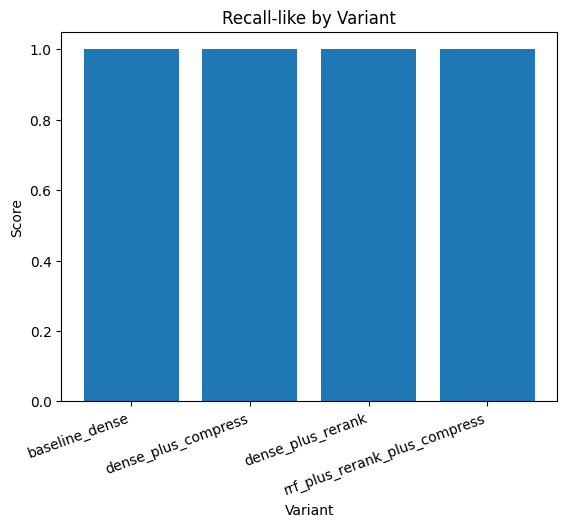

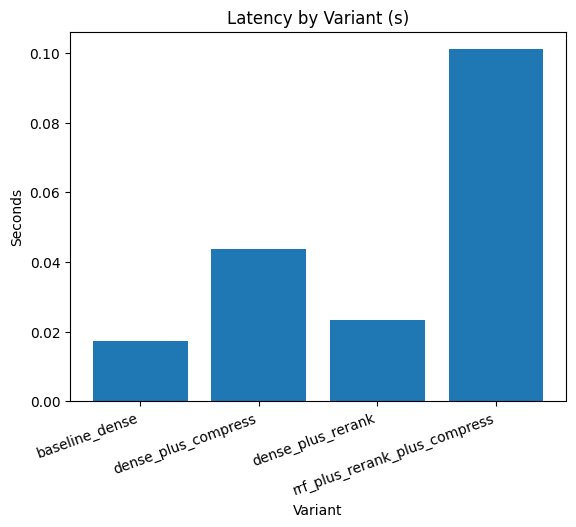

In [7]:
import matplotlib.pyplot as plt

plot_df = df.rename(columns={"hit_gold":"recall_like"})
summary = (
    plot_df
    .groupby("pipeline", as_index=False)
    .agg({"recall_like":"mean", "latency_sec":"mean", "avg_ctx_chars":"mean"})
    .sort_values("pipeline")
)
print(summary)

plt.figure()
plt.bar(summary["pipeline"], summary["recall_like"])
plt.title("Recall-like by Variant")
plt.xlabel("Variant")
plt.ylabel("Score")
plt.xticks(rotation=20, ha="right")
plt.show()

plt.figure()
plt.bar(summary["pipeline"], summary["latency_sec"])
plt.title("Latency by Variant (s)")
plt.xlabel("Variant")
plt.ylabel("Seconds")
plt.xticks(rotation=20, ha="right")
plt.show()

In [ ]:
def show_example(q: str, k=K):
    print("\nQ:", q)
    for name, pipe in pipelines.items():
        try:
            docs = pipe(q, k=k)
        except TypeError:
            docs = pipe.get_relevant_documents(q)[:k]
        print(f"\n[{name}] Top {len(docs)} sources:")
        for j, d in enumerate(docs, 1):
            src = d.metadata.get("source") or d.metadata.get("file_path") or d.metadata.get("doc_id") or "?"
            print(f" {j}.", os.path.basename(str(src)), "→", d.page_content[:140].replace("\n"," ") + "...")

if len(eval_items) >= 2:
    show_example(eval_items[0]["question"])
    show_example(eval_items[1]["question"])
elif len(eval_items) == 1:
    show_example(eval_items[0]["question"])

In [ ]:
def pv(m):
    try:
        mod = importlib.import_module(m)
        return getattr(mod, "__version__", "unknown")
    except: return "not installed"

env_adv = {
  "timestamp": datetime.datetime.now().isoformat(timespec="seconds"),
  "python": sys.version, "platform": platform.platform(),
  "cuda_available": torch.cuda.is_available() if 'torch' in sys.modules else False,
  "packages": {m: pv(m) for m in [
    "langchain","langchain_community","chromadb","transformers",
    "sentence_transformers","rank_bm25"
  ]}
}
json.dump(env_adv, open("env_rag_adv.json","w"), indent=2)
print("✅ Saved: env_rag_adv.json")

# rag_adv_run_config.json (Week-5 run config snapshot)
run_cfg = {
    "corpus_dir": "corpus",
    "chunks": {"count": len(chunks), "chunk_size": 500, "chunk_overlap": 100},
    "embedding_models_tested": ["sentence-transformers/all-MiniLM-L6-v2","intfloat/e5-small-v2"],
    "retriever_k": 6,
    "pipelines": list(pipelines.keys()),
    "eval_items": len(eval_items),
    "outputs": {"ablation_csv": "ablation_results.csv"}
}
json.dump(run_cfg, open("rag_adv_run_config.json","w"), indent=2)
print("✅ Saved: rag_adv_run_config.json")

print("\nAll Week-5 Track A steps complete. Submit: notebook + corpus folder + env_rag_adv.json + rag_adv_run_config.json + ablation_results.csv + short write-up.")